In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split

import sklearn.linear_model as sklm ##Includes Logistic Regression, which will be tested for predictive capability
import sklearn.decomposition as skdc ##Includes Principal Component Analysis, a method of dimensionality reduction
import sklearn.pipeline as skpl ##Convenient module for calculating PCs and using them in logistic regression
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split

In [4]:
train = pd.read_csv('../data/cleaned_data.csv')
print("Shape of Train :", train.shape)
train.head()
minority_count = train['loan_default'].value_counts()[1]

Shape of Train : (233154, 38)


In [5]:
train.Employment_Type = pd.Categorical(train.Employment_Type)
train['EMP_TYPE'] = train.Employment_Type.cat.codes
train.PERFORM_CNS_SCORE_DESCRIPTION = pd.Categorical(train.PERFORM_CNS_SCORE_DESCRIPTION)
train['CNS_DESC_CODES'] = train.PERFORM_CNS_SCORE_DESCRIPTION.cat.codes

train = train.drop(columns = ['PERFORM_CNS_SCORE_DESCRIPTION','Employment_Type'],axis=1)
train.info()
train.head()

df = train.copy()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 38 columns):
disbursed_amount                       233154 non-null int64
asset_cost                             233154 non-null int64
ltv                                    233154 non-null float64
branch_id                              233154 non-null int64
supplier_id                            233154 non-null int64
manufacturer_id                        233154 non-null int64
Current_pincode_ID                     233154 non-null int64
State_ID                               233154 non-null int64
Employee_code_ID                       233154 non-null int64
Aadhar_flag                            233154 non-null int64
PAN_flag                               233154 non-null int64
VoterID_flag                           233154 non-null int64
Driving_flag                           233154 non-null int64
Passport_flag                          233154 non-null int64
PERFORM_CNS_SCORE                

,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,State_ID,Employee_code_ID,Aadhar_flag,...,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,Age,EMP_TYPE,CNS_DESC_CODES
0,50578,58400,89.55,67,22807,45,1441,6,1998,1,...,0,0,0,0.000000,0.000000,0,0,34,0,13
1,47145,65550,73.23,67,22807,45,1502,6,1998,1,...,0,0,1,1.916667,1.916667,0,1,33,1,8
2,53278,61360,89.63,67,22807,45,1497,6,1998,1,...,0,0,0,0.000000,0.000000,0,0,33,1,13
3,57513,66113,88.48,67,22807,45,1501,6,1998,1,...,0,0,0,0.666667,1.250000,1,1,25,1,11
4,52378,60300,88.39,67,22807,45,1495,6,1998,1,...,0,0,0,0.000000,0.000000,1,1,41,1,13


In [6]:
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = df[df.loan_default==0]
df_minority = df[df.loan_default==1]
 
# Downsampling majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=minority_count,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.loan_default.value_counts()

1    50611
0    50611
Name: loan_default, dtype: int64

In [7]:
print(df_majority.loan_default.value_counts())
print(df_minority.loan_default.value_counts())

0    182543
Name: loan_default, dtype: int64
1    50611
Name: loan_default, dtype: int64


In [8]:
# #one-hot encoding
# encoded_data = pd.get_dummies(df_downsampled,prefix=['BI','SI','MI','CPID','ET','SID','ECID','AF','PF','VF','DF','PAF','PCS','PCSD','LD'],columns=['branch_id','supplier_id','manufacturer_id','Current_pincode_ID','EMP_TYPE','State_ID','Employee_code_ID','Aadhar_flag','PAN_flag','VoterID_flag','Driving_flag','Passport_flag','PERFORM_CNS_SCORE','CNS_DESC_CODES','loan_default'],drop_first=1) 
# print(encoded_data.head())
# print("Done")

        disbursed_amount  asset_cost    ltv  PRI.NO.OF.ACCTS  \
16352              52303       75141  71.86                0   
175752             33100       67800  49.85                1   
194345             53683       72260  80.27                2   
9414               56553       68110  85.00                0   
144365             54303       67400  81.60                0   

        PRI.ACTIVE.ACCTS  PRI.OVERDUE.ACCTS  PRI.CURRENT.BALANCE  \
16352                  0                  0                    0   
175752                 0                  0                    0   
194345                 1                  0                 8861   
9414                   0                  0                    0   
144365                 0                  0                    0   

        PRI.SANCTIONED.AMOUNT  PRI.DISBURSED.AMOUNT  SEC.NO.OF.ACCTS  ...   \
16352                       0                     0                0  ...    
175752                      0                     

In [9]:
def standardization(x): #Define function to standardize the data, since all variables are not in the same units
    xmean = np.mean(x) ##calculate mean
    sd = np.std(x) ##calculate standard deviation 
    x_z = (x - xmean) / sd ##calculate standardized value to return
    return(x_z)

In [ ]:
data_stnd = df_downsampled.drop(['loan_default'], 1).apply(standardization,broadcast = True) 
##drop response variable and standardize predictor variables

0     0.126923
1     0.099357
2     0.066368
3     0.056140
4     0.048455
5     0.043274
6     0.042210
7     0.040173
8     0.038197
9     0.036768
10    0.028767
11    0.027681
12    0.027119
13    0.026545
14    0.025515
15    0.025202
16    0.024819
17    0.023822
18    0.023331
19    0.022217
20    0.020923
21    0.020360
22    0.019270
23    0.018106
24    0.016014
25    0.013872
26    0.012034
27    0.010354
28    0.004626
29    0.003474
30    0.003304
31    0.001962
32    0.001574
33    0.000856
34    0.000373
35    0.000012
36    0.000003
dtype: float64
[ 12.69  22.63  29.27  34.88  39.73  44.06  48.28  52.3   56.12  59.8
  62.68  65.45  68.16  70.81  73.36  75.88  78.36  80.74  83.07  85.29
  87.38  89.42  91.35  93.16  94.76  96.15  97.35  98.39  98.85  99.2
  99.53  99.73  99.89  99.98 100.02 100.02 100.02]


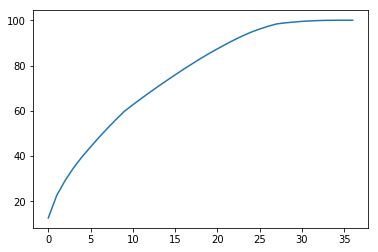

In [11]:
X = data_stnd #store predictor variables
y = df_downsampled['loan_default'] #store response variable

#Principal Component Analysis
pca = skdc.PCA() #empty model space
pcafit = pca.fit_transform(X,y) ##apply dimensionality reduction to X

var_explained = pca.explained_variance_ratio_ #ratio of variance each PC explains
print(pd.Series(var_explained))

#Cumulative Variance explains
cumulative_var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

print(cumulative_var)

# import matplotlib.pyplot as plt
plt.plot(cumulative_var)

In [14]:
col_names = list(df.columns.values)
col_names_dict = { i : col_names[i] for i in range(0, len(col_names)) }
# print(col_names_dict)
pca_df = pd.DataFrame(data=pca.components_)
pca_df.rename(columns=col_names_dict, inplace=True)
pca_df_trans = pca_df.transpose()
print(pca_df_trans)
# pca_df = pca_df.rename(columns={0:'PC1',1:'PC2',2:'PC3',3:'PC4',4:'PC5',5:'PC6',6:'PC7',7:'PC8',8:'PC9',9:'PC10',10:'PC11',11:'PC12',12:'PC13',13:'PC14',14:'PC15',15:'PC16',16:'PC17',17:'PC18',18:'PC19',19:'PC20',20:'PC21',21:'PC22',22:'PC23',23:'PC24',24:'PC25',25:'PC26'}, inplace=True)
# print(pca_df)
pca_df_trans.to_excel("../data/pca_df_trans.xlsx")

                                           0         1         2         3   \
disbursed_amount                     0.000310 -0.015274  0.148364 -0.013902   
asset_cost                          -0.050059  0.011006  0.296956 -0.019426   
ltv                                  0.072520 -0.036973 -0.211493  0.006986   
branch_id                           -0.015721  0.010274  0.109546 -0.028559   
supplier_id                         -0.060842  0.023048  0.203049 -0.021387   
manufacturer_id                      0.051552 -0.025981 -0.076049 -0.003689   
Current_pincode_ID                  -0.110358  0.041469  0.376176 -0.043492   
State_ID                            -0.023407  0.037960  0.172590 -0.048355   
Employee_code_ID                    -0.003258 -0.002951 -0.002799  0.004863   
Aadhar_flag                          0.072597 -0.042917 -0.489081  0.146738   
PAN_flag                            -0.008165  0.024625  0.194391 -0.076402   
VoterID_flag                        -0.072279  0.041

In [15]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.3,random_state = 2001)

In [ ]:
pca = skdc.PCA(n_components = 26) #only include first 26 components
logreg = sklm.LogisticRegression()#empty model space
pipeline = skpl.Pipeline([('pca', pca), ('logistic', logreg)]) #create pipeline from pca to logregression space
fit = pipeline.fit(X_train, Y_train) #fit model
prediction = pipeline.predict(X_test) #test model with left out value

In [17]:
print( accuracy_score(Y_test, prediction))
print( roc_auc_score(Y_test, prediction))

0.5964369216583791
0.5961509465088101


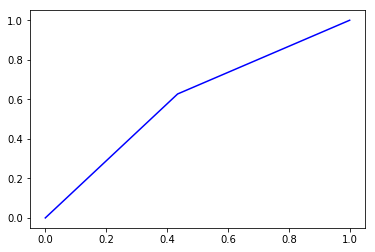

In [18]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(Y_test, prediction)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)